## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from numpy.linalg import inv
import random
%matplotlib inline


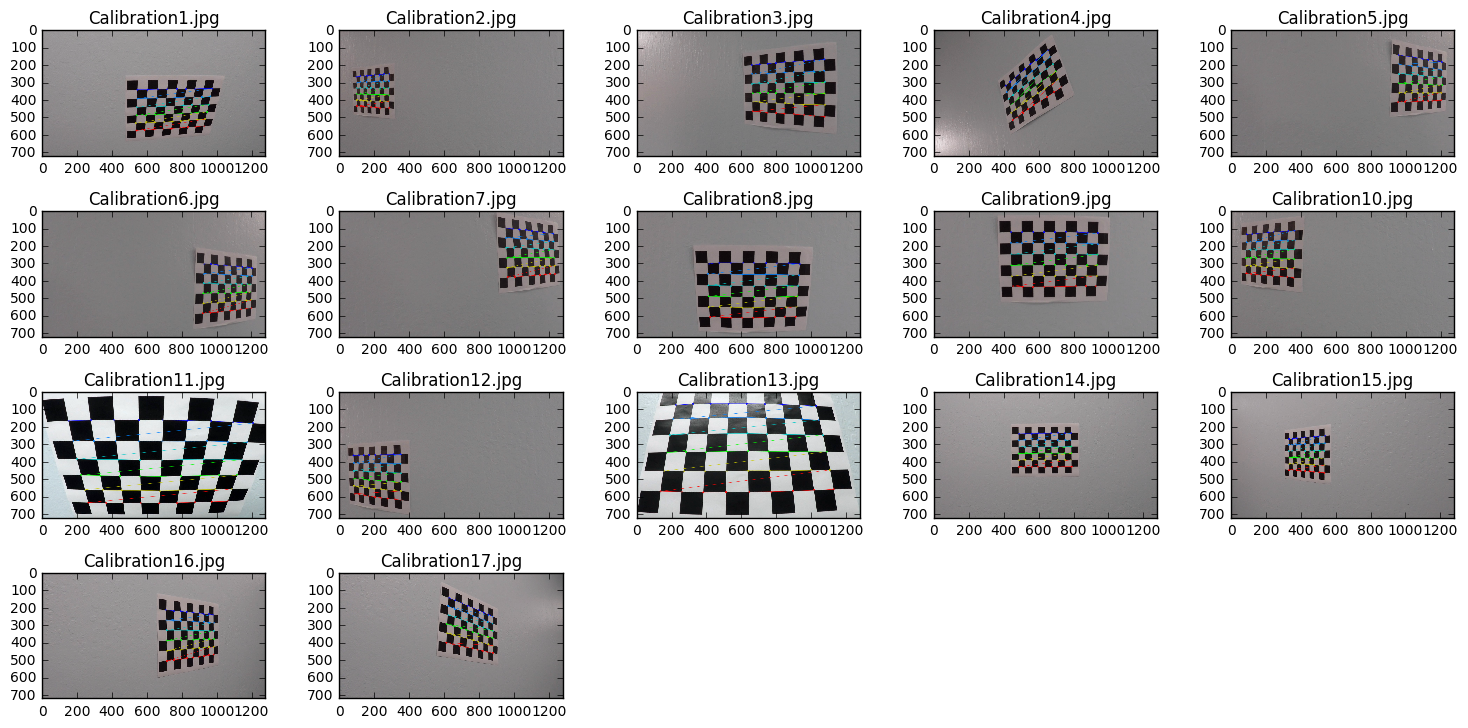

In [2]:
# Calibration
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
plt.figure(figsize=(15,9))
n_img = len(images)
i = -1
for fname in images:
    img = cv2.imread(fname)
    image = img
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        i+=1
        plt.subplot(n_img/5+1,5,i+1)
        plt.title("Calibration"+str(i+1)+".jpg")
        plt.tight_layout()
        plt.imshow(img)
plt.savefig("./output_images/Calibration.png")
# calibrate
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


## 2. Apply a distortion correction to raw images

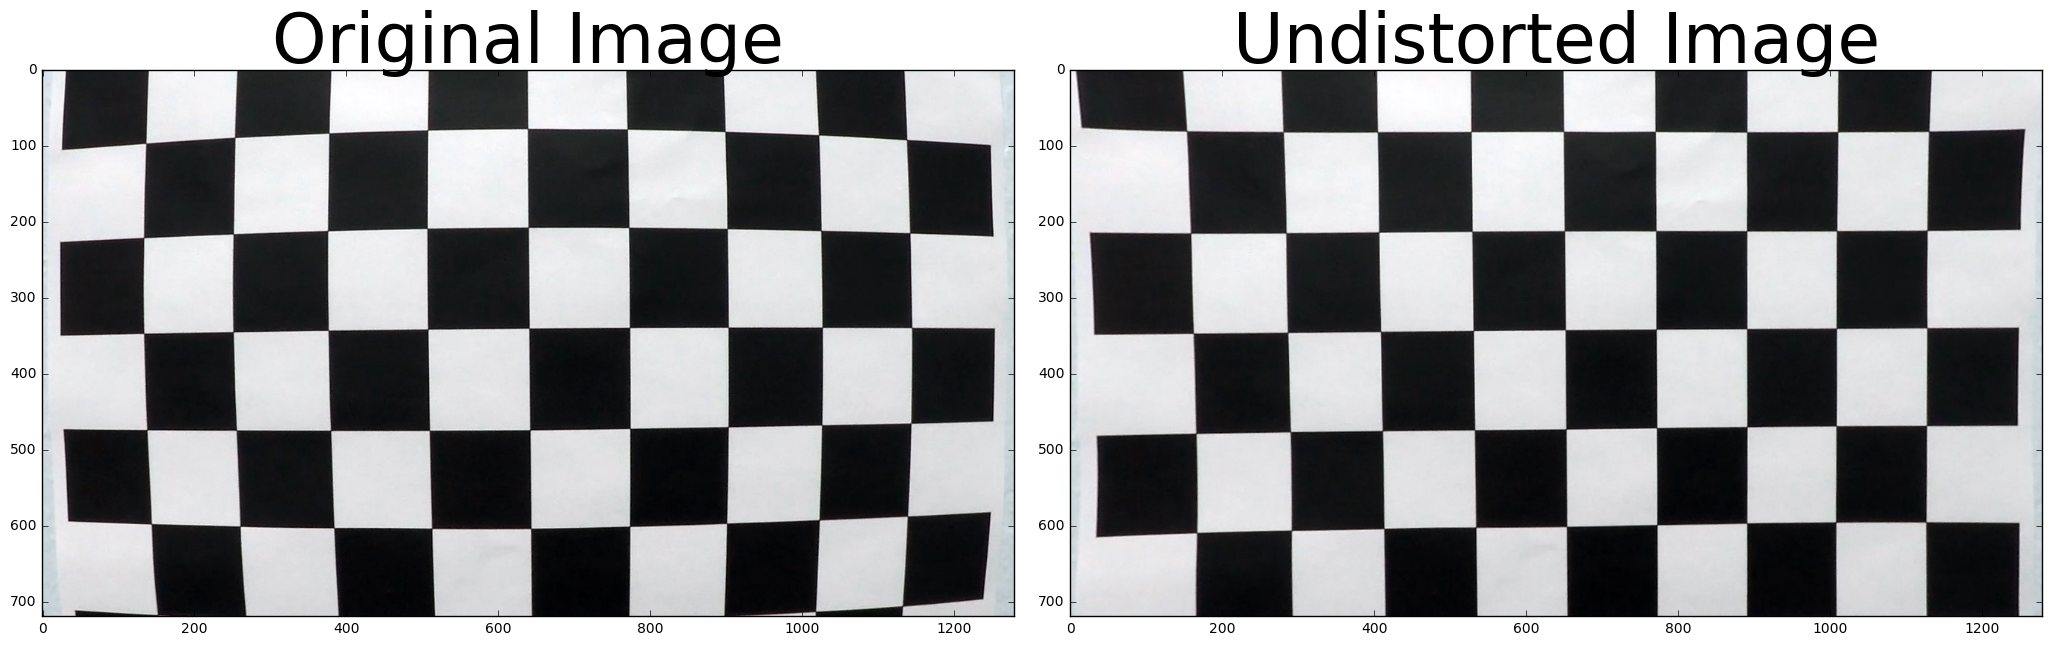

In [3]:
# Apply a distortion correction to raw images
img = cv2.imread('./camera_cal/calibration1.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h)) #自由比例参数
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# 根据前面ROI区域裁剪图片
x,y,w,h = roi
dst = dst[y:y+h,x:x+w]

# Plot Original Image and Undistorted Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("./output_images/undistort_output.png")


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

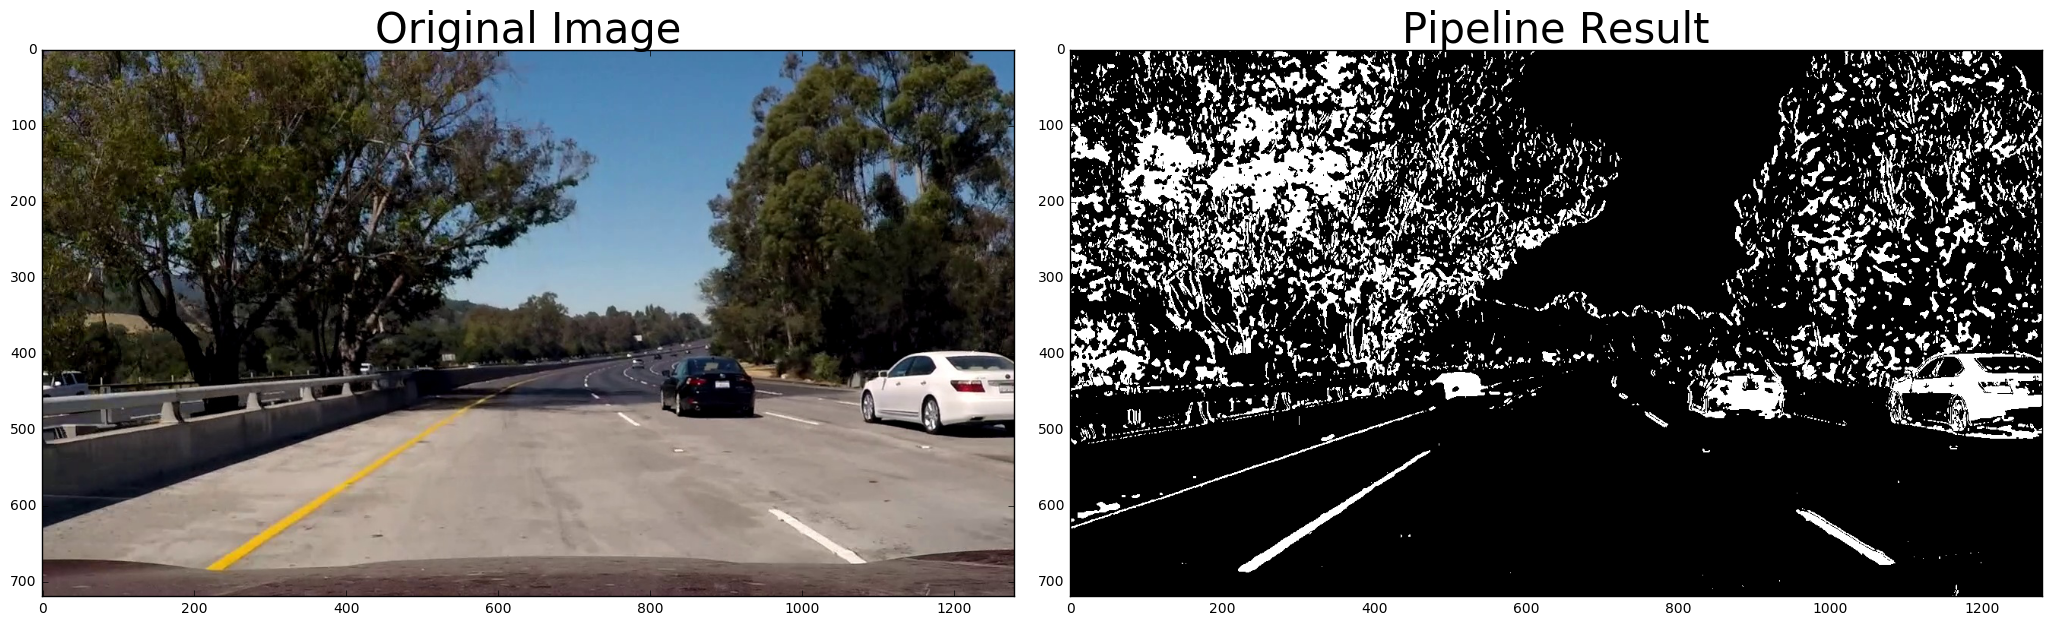

In [19]:
def pipeline(image, s_thresh = (170, 255),r_thresh=(225,255),sx_thresh=(20,100)):
    img = np.copy(image)
    # Convert to HSV color space and separate the V channel
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5), 0)   # Blur image
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)#.astype(np.float)
    hsv = cv2.medianBlur(hsv, 5)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls = cv2.medianBlur(hls, 5)

    l_channel = hls[:,:,1] # L channel used to track the bright regions
    s_channel = hsv[:,:,1] # S channel used to pick up lines under very different color and contrast conditions
    s_channel = cv2.morphologyEx(s_channel, cv2.MORPH_OPEN, kernel=(7,7))#.astype(np.float)
    s_channel = cv2.morphologyEx(s_channel, cv2.MORPH_CLOSE, kernel=(7,7))
    r_channel = img[:,:,0] # R channel doing well on the white lines
    r_channel = cv2.morphologyEx(r_channel, cv2.MORPH_OPEN, kernel=(7,7))#.astype(np.float)
    r_channel = cv2.morphologyEx(r_channel, cv2.MORPH_CLOSE, kernel=(7,7))
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # plt.imshow(sxbinary, cmap='gray')

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    r_binary = np.zeros_like(r_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    # plt.imshow(s_binary, cmap='gray')
    
    # Stack each channel
    # Note color_binary[:,:,0] is all 0s, effectively an all black image. I might be beneficial to replace this channel with something else.
    combine_binary = np.zeros_like(s_channel)
    combine_binary[((r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])) | ((scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])) | ((s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]))] = 1
    #color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    return combine_binary

"""
# Plot image

images = glob.glob('./test_images/*.jpg')
proccessed_images = []

for single_image in images:
    image = mpimg.imread(single_image)
    result = pipeline(image)
    result_save = np.uint8(255*result/np.max(result))
    proccessed_images.append(result_save)
    
plt.figure(figsize=(15,15))
for i in range(len(proccessed_images)):
        plt.subplot(len(proccessed_images)/2+1,2,i+1)#
        plt.title("test"+str(i)+":")
        plt.imshow(proccessed_images[i], cmap ='gray')
        plt.tight_layout()
        #print("the label is", y_train[index])

plt.savefig('./output_images/binary_combo_text_example.jpg')

"""
image = mpimg.imread('./videoimagesave/1025.jpg')
result = pipeline(image)
result_save = np.uint8(255*result/np.max(result))
#cv2.imwrite('./output_images/binary_combo_example.jpg', result_save)

# Plot the pipeline result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9 ))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(result, cmap="gray")
ax2.set_title('Pipeline Result', fontsize=30)
plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)
plt.savefig('./output_images/binary_combo_example.jpg')



## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

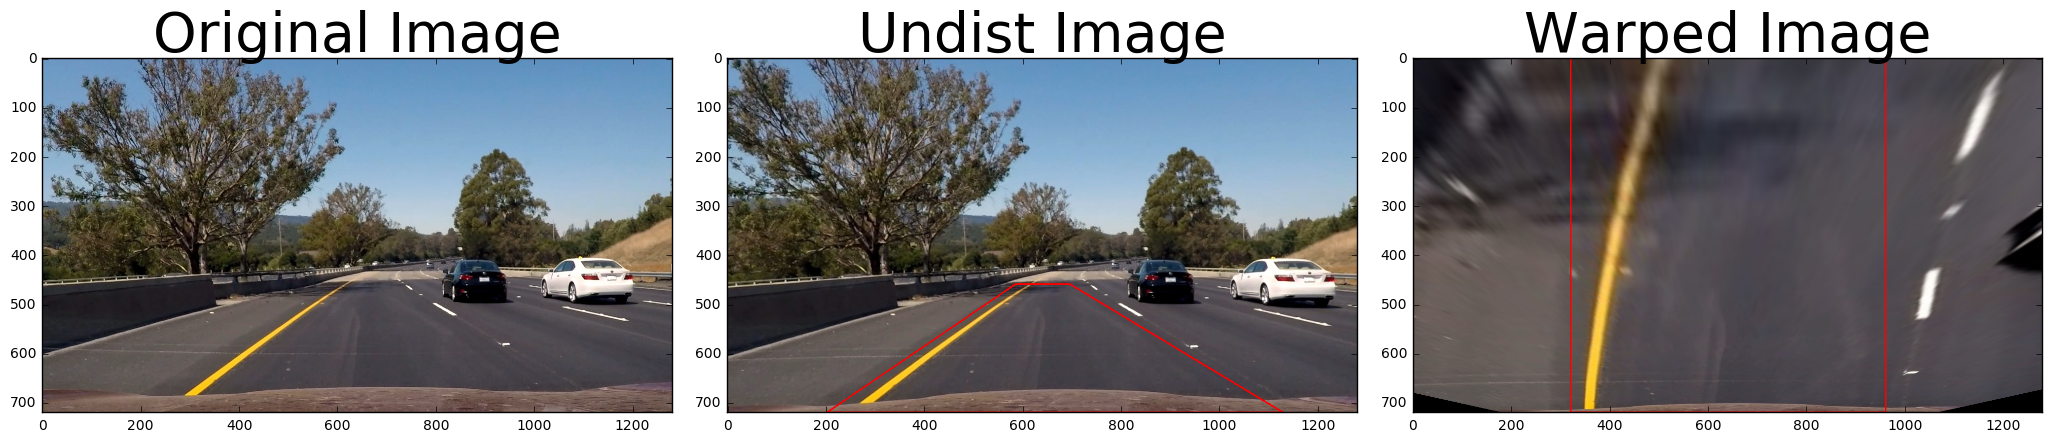

In [10]:
# Define a function that takes an image, number of x and y points,
# camera matrix and distortion coefficients
def warpPerspective_step(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    img_size = (gray.shape[1], gray.shape[0])
    src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
    dst = np.float32([[320,0],  [320,720],[960,720], [960,0]])

    #cv2.line(img,(0,0),(511,511),(255,0,0),5)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    undist_withoutlines = np.copy(undist)
    warped_withoutlines = np.copy(warped)
    # Return the resulting image and matrix
    cv2.line(undist,(585,460),(203,720),(255,0,0),2)
    cv2.line(undist,(203,720),(1127,720),(255,0,0),2)
    cv2.line(undist,(1127,720),(695,460),(255,0,0),2)
    cv2.line(undist,(695,460),(585,460),(255,0,0),2)
    
    cv2.line(warped,(320,0),(320,720),(255,0,0),2)
    cv2.line(warped,(320,720),(960,720),(255,0,0),2)
    cv2.line(warped,(960,720),(960,0),(255,0,0),2)
    cv2.line(warped,(960,0),(320,0),(255,0,0),2)
    return undist, warped, undist_withoutlines, warped_withoutlines, M

# Plot
# Read image
image = mpimg.imread('./test_images/test6.jpg')
undist, warped, undist_withoutlines, warped_withoutlines, M = warpPerspective_step(image, nx, ny, mtx, dist)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 9 ))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(undist)
ax2.set_title('Undist Image', fontsize=40)

ax3.imshow(warped)
ax3.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)

# save plot
plt.savefig("./output_images/warped_straight_lines.jpg")


## 5. Line Finding Method: Peaks in a Histogram

C:\Anaconda3\envs\CarND\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


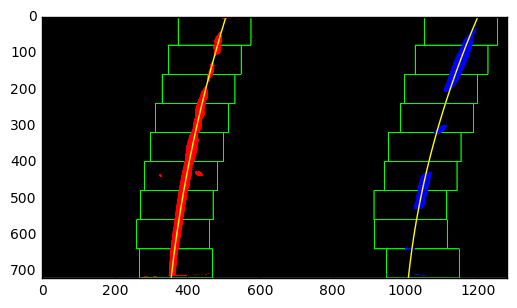

In [11]:
def Finding_lines(warped):
    #global Middle_road_Position
    gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    ret, binary_warped = cv2.threshold(gray_warped, 127, 255, cv2.THRESH_BINARY)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    Middle_road_Position = (leftx_base+rightx_base)/2.0
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one 
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0),2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0),2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return binary_warped, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, Middle_road_Position


# Plot ---------------------------------------------------------------------------------------------------------------------
binary_warped, out_img, left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, Middle_road_Position = Finding_lines(warped)
# Visualization
# Generate x and y values for plotting
# Visualization
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("./output_images/color_fit_lines0.jpg")


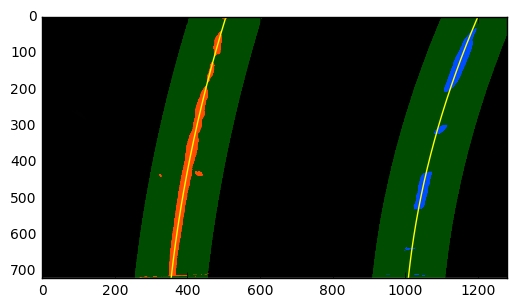

In [12]:
# Create an image to draw on and an image to show the selection window
margin = 100
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig("./output_images/color_fit_lines.jpg")

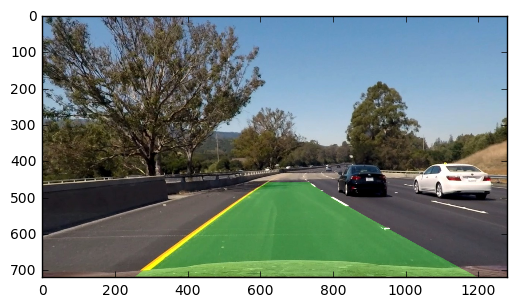

In [13]:
# Define drawing function
def Drawing(warped, undist_withoutlines, left_fit, right_fit):
    global color_warp
    #global left_fit, right_fit, leftx, lefty, rightx, righty
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros_like(warped)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_withoutlines, 1, newwarp, 0.3, 0)
    return result

result = Drawing(warped, undist_withoutlines, left_fit, right_fit)
plt.imshow(result)

## Measuring Curvature

In [14]:
# Measuring Curvature
def cal_Curvature(warped, left_fit, right_fit, leftx, lefty, rightx, righty):

    #global left_fit, right_fit, leftx, lefty, rightx, righty
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    
    # Fit new polynomials to x,y in world space
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m


# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
    
left_curverad, right_curverad = cal_Curvature(warped, left_fit, right_fit, leftx, lefty, rightx, righty)
print(left_curverad)
print(right_curverad)

1206.28394154
730.799035123


In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
# Test on  Videos
# processing each frame
frame_n = 0
alpha = 0.8
def process_image(image):
    
    global frame_n, left_best_fit, right_best_fit
    global old_color_warp
    frame_n += 1
    
    undist, warped, undist_withoutlines, warped_withoutlines, M = warpPerspective_step(image, nx, ny, mtx, dist)
    
    fity = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    
    if frame_n == 1:
        binary_warped, out_img, left_current_fit, right_current_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds, Middle_road_Position = Finding_lines(warped)
        
        left_best_fit = left_current_fit
        right_best_fit = right_current_fit
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        color_warp = np.zeros_like(warped)
        
        left_fitx = left_best_fit[0]*fity**2 + left_best_fit[1]*fity + left_best_fit[2]
        right_fitx = right_best_fit[0]*fity**2 + right_best_fit[1]*fity + right_best_fit[2]
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        color_warp = np.zeros_like(warped)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        old_color_warp = color_warp
        
        left_curverad, right_curverad = cal_Curvature(warped, left_best_fit, right_best_fit, leftx, lefty, rightx, righty)
        
    else:
        gray_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
        ret, binary_warped = cv2.threshold(gray_warped, 127, 255, cv2.THRESH_BINARY)
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        Middle_road_Position = (leftx_base+rightx_base)/2.0
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_best_fit[0]*(nonzeroy**2) + left_best_fit[1]*nonzeroy + left_best_fit[2] - margin)) & (nonzerox < (left_best_fit[0]*(nonzeroy**2) + left_best_fit[1]*nonzeroy + left_best_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_best_fit[0]*(nonzeroy**2) + right_best_fit[1]*nonzeroy + right_best_fit[2] - margin)) & (nonzerox < (right_best_fit[0]*(nonzeroy**2) + right_best_fit[1]*nonzeroy + right_best_fit[2] + margin)))  
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_current_fit = np.polyfit(lefty, leftx, 2)
        right_current_fit = np.polyfit(righty, rightx, 2)
        
        left_fitx = left_current_fit[0]*fity**2 + left_current_fit[1]*fity + left_current_fit[2]
        right_fitx = right_current_fit[0]*fity**2 + right_current_fit[1]*fity + right_current_fit[2]
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        color_warp = np.zeros_like(warped)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        gray1 = cv2.cvtColor(old_color_warp, cv2.COLOR_RGB2GRAY)
        gray2 = cv2.cvtColor(color_warp, cv2.COLOR_RGB2GRAY)
        ret, thresh1 = cv2.threshold(gray1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        ret, thresh2 = cv2.threshold(gray2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        img, contours,hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cnt1 = contours[0]
        img, contours,hierarchy = cv2.findContours(thresh2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cnt2 = contours[0]
        
        # Smooth/Compute best fit over last n frame
        if cv2.matchShapes(cnt1,cnt2,1,0.0)<0.1:
            
            current_left_fitx = left_current_fit[0]*fity**2+left_current_fit[1]*fity+left_current_fit[2]
            last_left_fitx = left_best_fit[0]*fity**2 + left_best_fit[1]*fity + left_best_fit[2]
            left_fit_x = last_left_fitx * alpha + current_left_fitx * (1-alpha)
            left_best_fit = np.polyfit(fity, left_fit_x, 2)
            
            current_right_fitx = right_current_fit[0]*fity**2+right_current_fit[1]*fity+right_current_fit[2]
            last_rihgt_fit_x = right_best_fit[0]*fity**2 + right_best_fit[1]*fity + right_best_fit[2]
            right_fit_x = last_rihgt_fit_x * alpha + current_right_fitx * (1-alpha)
            right_best_fit = np.polyfit(fity, right_fit_x, 2)
            
            old_color_warp = color_warp
        
        left_curverad, right_curverad = cal_Curvature(warped, left_best_fit, right_best_fit, leftx, lefty, rightx, righty)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = inv(M)
    newwarp = cv2.warpPerspective(old_color_warp, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(undist_withoutlines, 1, newwarp, 0.3, 0)
    
    text_str1 = "Radius of Left Curvature = "+ str(round(left_curverad,1))+'(m)'
    text_str2 = "Radius of Right Curvature= "+ str(round(right_curverad,1))+'(m)'
    cv2.putText(result,text_str1,(100,80), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),3)
    cv2.putText(result,text_str2,(100,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),3)
    if Middle_road_Position>warped.shape[1]/2.0:
        text_str3 = "Vehicle is "+str(round((Middle_road_Position-warped.shape[1]/2.0)*3.7/700,1)) + "m right of center"
    else:
         text_str3 = "Vehicle is "+str(round((warped.shape[1]/2.0 - Middle_road_Position)*3.7/700,1)) + "m left of center"
    cv2.putText(result,text_str3,(100,160), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(255,255,255),3)
    #result = np.copy(image)
    
    randon_n = random.randint(1,20)
    if randon_n <2:
        frame_n = 0 #randon_n can make pipeline to restart an blind search with a probability of 10%, to provent provious fault
    
    return result


In [17]:
project_output = 'projec_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video projec_output.mp4
[MoviePy] Writing video projec_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [01:59<00:00, 12.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: projec_output.mp4 

Wall time: 2min


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))